In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [24]:
df_sub=pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")
df_train=pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
df_test=pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef
import warnings
warnings.filterwarnings('ignore')

In [26]:
df_train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [27]:
new_columns = {'class': 'class','cap-diameter':'cap_diameter','cap-shape':'cap_shape','cap-surface':'cap_surface',
             'cap-color':'cap_color','does-bruise-or-bleed':'does_bruise_or_bleed','gill-attachment':'gill_attachment',
            'gill-spacing':'gill_spacing','gill-color':'gill_color','stem-height':'stem_height','stem-width':'stem_width',
            'stem-root':'stem_root','stem-surface':'stem_surface','stem-color':'stem_color','veil-type':'veil_type',
            'veil-color':'veil_color','has-ring':'has_ring','ring-type':'ring_type','spore-print-color':'spore_print_color',
            'habitat':'habitat','season':'season'}
df_train.rename(columns = new_columns, inplace = True)
df_train.columns

Index(['id', 'class', 'cap_diameter', 'cap_shape', 'cap_surface', 'cap_color',
       'does_bruise_or_bleed', 'gill_attachment', 'gill_spacing', 'gill_color',
       'stem_height', 'stem_width', 'stem_root', 'stem_surface', 'stem_color',
       'veil_type', 'veil_color', 'has_ring', 'ring_type', 'spore_print_color',
       'habitat', 'season'],
      dtype='object')

In [28]:
new_columns = {'class': 'class','cap-diameter':'cap_diameter','cap-shape':'cap_shape','cap-surface':'cap_surface',
             'cap-color':'cap_color','does-bruise-or-bleed':'does_bruise_or_bleed','gill-attachment':'gill_attachment',
            'gill-spacing':'gill_spacing','gill-color':'gill_color','stem-height':'stem_height','stem-width':'stem_width',
            'stem-root':'stem_root','stem-surface':'stem_surface','stem-color':'stem_color','veil-type':'veil_type',
            'veil-color':'veil_color','has-ring':'has_ring','ring-type':'ring_type','spore-print-color':'spore_print_color','habitat':'habitat','season':'season'}
df_test.rename(columns = new_columns, inplace = True )
df_test.columns

Index(['id', 'cap_diameter', 'cap_shape', 'cap_surface', 'cap_color',
       'does_bruise_or_bleed', 'gill_attachment', 'gill_spacing', 'gill_color',
       'stem_height', 'stem_width', 'stem_root', 'stem_surface', 'stem_color',
       'veil_type', 'veil_color', 'has_ring', 'ring_type', 'spore_print_color',
       'habitat', 'season'],
      dtype='object')

In [29]:
#Removing columns with more than 80% null values
df_train.drop(['veil_type','spore_print_color','stem_root','veil_color'], axis =1, inplace = True)

In [30]:
col_name = ['cap_diameter', 'stem_height', 'stem_width']

def outlier_thresholds(df_train, col_name, q1=0.01, q3=0.99):
    quartile1 = df_train[col_name].quantile(q1)
    quartile3 = df_train[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(df_train, col_name):
    low_limit, up_limit = outlier_thresholds(df_train, col_name)
    if df_train[(df_train[col_name] > up_limit) | (df_train[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(df_train, variable):
    low_limit, up_limit = outlier_thresholds(df_train, variable)
    df_train.loc[(df_train[variable] < low_limit), variable] = low_limit
    df_train.loc[(df_train[variable] > up_limit), variable] = up_limit

In [31]:
from sklearn.impute import SimpleImputer

filled_df = df_train.copy()
num_cols = filled_df.select_dtypes(include=['number']).columns
cat_cols = filled_df.select_dtypes(include=['object']).columns

numeric_imputer = SimpleImputer(strategy='median') 
filled_df[num_cols] = numeric_imputer.fit_transform(filled_df[num_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
filled_df[cat_cols] = categorical_imputer.fit_transform(filled_df[cat_cols])

In [32]:
# Drop the 'id' column and encode categorical features
categorical_cols = [
    'cap_shape', 'cap_surface', 'cap_color', 'does_bruise_or_bleed',
    'gill_attachment', 'gill_spacing', 'gill_color', 'stem_surface',
    'stem_color', 'has_ring', 'ring_type', 'habitat', 'season'
]

In [33]:
# numeric value and output column name : median

for col in categorical_cols:
  print(col, ":", filled_df[col].mode()[0])


cap_shape : x
cap_surface : t
cap_color : n
does_bruise_or_bleed : f
gill_attachment : a
gill_spacing : c
gill_color : w
stem_surface : s
stem_color : w
has_ring : f
ring_type : f
habitat : d
season : a


In [34]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# Assuming 'train' DataFrame and 'categorical_cols' list are already defined

# Iterate over categorical columns and encode them
for col in categorical_cols:
  label_encoder = LabelEncoder()
  filled_df[col] = label_encoder.fit_transform(filled_df[col])

# Encode the target column
le_target = LabelEncoder()
filled_df['class'] = le_target.fit_transform(filled_df['class'])

print(filled_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 18 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    float64
 1   class                 int64  
 2   cap_diameter          float64
 3   cap_shape             int64  
 4   cap_surface           int64  
 5   cap_color             int64  
 6   does_bruise_or_bleed  int64  
 7   gill_attachment       int64  
 8   gill_spacing          int64  
 9   gill_color            int64  
 10  stem_height           float64
 11  stem_width            float64
 12  stem_surface          int64  
 13  stem_color            int64  
 14  has_ring              int64  
 15  ring_type             int64  
 16  habitat               int64  
 17  season                int64  
dtypes: float64(4), int64(14)
memory usage: 428.0 MB
None


In [35]:
# Separate features and target
X = filled_df.drop(['class','id'], axis=1)
y = filled_df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 1e2),      
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 1e2),
        'seed': 42
    }


    # Create LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    # print(train_data.data.info())
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    # print(test_data.data.info())

    # Train the model
    model = lgb.train(params, train_data, valid_sets=[test_data])

    # Make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred_binary)

    return accuracy

In [37]:
# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust the number of trials as needed

# Print the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)


[I 2024-08-31 18:23:00,272] A new study created in memory with name: no-name-3a79282e-11f5-47af-9a76-8881c148ca14


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:23:16,666] Trial 0 finished with value: 0.70107589322237 and parameters: {'learning_rate': 0.008692955784097636, 'num_leaves': 21, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.7302588929162503, 'colsample_bytree': 0.9339144888996918, 'lambda_l1': 0.15454804678575082, 'lambda_l2': 0.2318191510319676}. Best is trial 0 with value: 0.70107589322237.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.458145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:23:56,794] Trial 1 finished with value: 0.9899452829613612 and parameters: {'learning_rate': 0.0882991272399762, 'num_leaves': 91, 'max_depth': 43, 'min_child_samples': 5, 'subsample': 0.5140607213080992, 'colsample_bytree': 0.6379042199462314, 'lambda_l1': 0.047548316480607124, 'lambda_l2': 9.60438610017564}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.419731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:24:38,619] Trial 2 finished with value: 0.9820914388928903 and parameters: {'learning_rate': 0.010141006552347424, 'num_leaves': 97, 'max_depth': 36, 'min_child_samples': 17, 'subsample': 0.9653307030404371, 'colsample_bytree': 0.6994141078874108, 'lambda_l1': 0.01866590725478874, 'lambda_l2': 0.0021904358532587654}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.438986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:25:18,790] Trial 3 finished with value: 0.9801199572016831 and parameters: {'learning_rate': 0.011587596099305259, 'num_leaves': 86, 'max_depth': 36, 'min_child_samples': 12, 'subsample': 0.8742976593114041, 'colsample_bytree': 0.7442959670615736, 'lambda_l1': 92.01711708752161, 'lambda_l2': 11.049919347937063}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:25:51,203] Trial 4 finished with value: 0.9811337704066001 and parameters: {'learning_rate': 0.033399626057123606, 'num_leaves': 82, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.6309926086701096, 'colsample_bytree': 0.961678134036168, 'lambda_l1': 0.0255483362096881, 'lambda_l2': 38.72958962861395}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.443297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:26:28,506] Trial 5 finished with value: 0.9830555239184522 and parameters: {'learning_rate': 0.025434072747653927, 'num_leaves': 64, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.786569352287712, 'colsample_bytree': 0.685478886217181, 'lambda_l1': 0.8480312711136737, 'lambda_l2': 0.033309220152463355}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:27:03,409] Trial 6 finished with value: 0.9350983094023154 and parameters: {'learning_rate': 0.0016605797569330884, 'num_leaves': 74, 'max_depth': 27, 'min_child_samples': 18, 'subsample': 0.9609596114304291, 'colsample_bytree': 0.8028792272126098, 'lambda_l1': 0.011153768578570096, 'lambda_l2': 1.4667995626918624}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:27:37,216] Trial 7 finished with value: 0.9885721435572331 and parameters: {'learning_rate': 0.08702913257274676, 'num_leaves': 58, 'max_depth': -1, 'min_child_samples': 15, 'subsample': 0.9909441523333837, 'colsample_bytree': 0.5690327231058334, 'lambda_l1': 23.619561506809738, 'lambda_l2': 22.27015247839915}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.416765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:28:05,253] Trial 8 finished with value: 0.5469971398276197 and parameters: {'learning_rate': 0.0012041547572085132, 'num_leaves': 21, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.8129998249942938, 'colsample_bytree': 0.6979446204207019, 'lambda_l1': 2.713278012307545, 'lambda_l2': 0.045732986722367815}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:28:41,514] Trial 9 finished with value: 0.8904103216450724 and parameters: {'learning_rate': 0.001076979605933462, 'num_leaves': 96, 'max_depth': -1, 'min_child_samples': 16, 'subsample': 0.5904832242932421, 'colsample_bytree': 0.9559412964985645, 'lambda_l1': 10.773337942739804, 'lambda_l2': 0.5453046548276232}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:29:12,382] Trial 10 finished with value: 0.9880989237859507 and parameters: {'learning_rate': 0.09531488611885858, 'num_leaves': 45, 'max_depth': 47, 'min_child_samples': 1, 'subsample': 0.5040334796440822, 'colsample_bytree': 0.5295616029116822, 'lambda_l1': 0.0024922337294041672, 'lambda_l2': 4.270668946444817}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:29:45,058] Trial 11 finished with value: 0.988402105266535 and parameters: {'learning_rate': 0.08469039387711137, 'num_leaves': 54, 'max_depth': 50, 'min_child_samples': 3, 'subsample': 0.6703938490960797, 'colsample_bytree': 0.5188236768569915, 'lambda_l1': 0.20686665875912047, 'lambda_l2': 97.75948968970211}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.421827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:30:18,543] Trial 12 finished with value: 0.9833218102982247 and parameters: {'learning_rate': 0.04412941463081498, 'num_leaves': 42, 'max_depth': 23, 'min_child_samples': 5, 'subsample': 0.5062857871416124, 'colsample_bytree': 0.6073796501245524, 'lambda_l1': 80.56609432026805, 'lambda_l2': 12.77780687568591}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.444186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:30:55,518] Trial 13 finished with value: 0.9870851105810337 and parameters: {'learning_rate': 0.05315997936948528, 'num_leaves': 62, 'max_depth': 40, 'min_child_samples': 14, 'subsample': 0.8804675260397727, 'colsample_bytree': 0.6033563224760359, 'lambda_l1': 8.918923245424844, 'lambda_l2': 3.0858866051714706}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.556180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:31:34,612] Trial 14 finished with value: 0.9834244749265707 and parameters: {'learning_rate': 0.02031850599198361, 'num_leaves': 74, 'max_depth': 27, 'min_child_samples': 20, 'subsample': 0.7138507376706188, 'colsample_bytree': 0.5945333347084255, 'lambda_l1': 0.08444557629947284, 'lambda_l2': 26.074437624114786}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.412724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:32:06,245] Trial 15 finished with value: 0.9833571012642186 and parameters: {'learning_rate': 0.05818080579491537, 'num_leaves': 35, 'max_depth': 20, 'min_child_samples': 6, 'subsample': 0.5695411965865302, 'colsample_bytree': 0.6316616147655445, 'lambda_l1': 0.0019414504232685742, 'lambda_l2': 72.18835716852539}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:32:38,628] Trial 16 finished with value: 0.9489804921164794 and parameters: {'learning_rate': 0.003327810892549865, 'num_leaves': 53, 'max_depth': 43, 'min_child_samples': 13, 'subsample': 0.8814589981536644, 'colsample_bytree': 0.8158075932810016, 'lambda_l1': 1.0526944065566113, 'lambda_l2': 0.7991229561892361}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:33:13,863] Trial 17 finished with value: 0.9836666992840747 and parameters: {'learning_rate': 0.018817493200042498, 'num_leaves': 76, 'max_depth': 32, 'min_child_samples': 15, 'subsample': 0.8108282417213085, 'colsample_bytree': 0.5351551873403952, 'lambda_l1': 17.66243153078998, 'lambda_l2': 0.0987045103000016}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.427485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:33:52,252] Trial 18 finished with value: 0.9789569594587008 and parameters: {'learning_rate': 0.005309885937704375, 'num_leaves': 89, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6600296542908293, 'colsample_bytree': 0.653415891815417, 'lambda_l1': 0.04649413291786953, 'lambda_l2': 7.273518197001343}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-08-31 18:34:18,270] Trial 19 finished with value: 0.9810118561604392 and parameters: {'learning_rate': 0.09814248096743573, 'num_leaves': 69, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.9984469887069287, 'colsample_bytree': 0.5648949687177764, 'lambda_l1': 0.6516458554823639, 'lambda_l2': 2.0316928823712637}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.429354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:34:55,422] Trial 20 finished with value: 0.9842923118630582 and parameters: {'learning_rate': 0.037419294277757066, 'num_leaves': 54, 'max_depth': 31, 'min_child_samples': 2, 'subsample': 0.5700015720242225, 'colsample_bytree': 0.7701445228051111, 'lambda_l1': 0.005608865456008533, 'lambda_l2': 0.007723578414885772}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:35:28,061] Trial 21 finished with value: 0.9876208916102145 and parameters: {'learning_rate': 0.0669275281002852, 'num_leaves': 54, 'max_depth': 49, 'min_child_samples': 3, 'subsample': 0.6710032762760858, 'colsample_bytree': 0.5002309624341514, 'lambda_l1': 0.21778515147708302, 'lambda_l2': 68.15984290083341}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:36:00,248] Trial 22 finished with value: 0.9871941917486513 and parameters: {'learning_rate': 0.07505506360868308, 'num_leaves': 47, 'max_depth': 46, 'min_child_samples': 3, 'subsample': 0.6104292378296264, 'colsample_bytree': 0.5674960398277862, 'lambda_l1': 3.141696736208078, 'lambda_l2': 95.35366845419607}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:36:30,065] Trial 23 finished with value: 0.977750650075635 and parameters: {'learning_rate': 0.02903881872398375, 'num_leaves': 37, 'max_depth': 42, 'min_child_samples': 6, 'subsample': 0.6996013882508453, 'colsample_bytree': 0.5000350174513594, 'lambda_l1': 0.07241107012127249, 'lambda_l2': 20.45348913654475}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.415463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:37:07,111] Trial 24 finished with value: 0.9892635256637509 and parameters: {'learning_rate': 0.09510293809798144, 'num_leaves': 66, 'max_depth': 50, 'min_child_samples': 4, 'subsample': 0.5422980103675109, 'colsample_bytree': 0.6476387940001724, 'lambda_l1': 0.3271976158121376, 'lambda_l2': 31.574420628983496}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.416631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:37:45,282] Trial 25 finished with value: 0.9868332614146224 and parameters: {'learning_rate': 0.04936677646272159, 'num_leaves': 67, 'max_depth': 38, 'min_child_samples': 7, 'subsample': 0.5360108023553001, 'colsample_bytree': 0.6675763690524468, 'lambda_l1': 44.96516815369783, 'lambda_l2': 8.011031256291902}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.440875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:38:29,580] Trial 26 finished with value: 0.9889234490823546 and parameters: {'learning_rate': 0.06436380930967336, 'num_leaves': 100, 'max_depth': 43, 'min_child_samples': 4, 'subsample': 0.5474323543863042, 'colsample_bytree': 0.7414210879390892, 'lambda_l1': 2.5287901218871527, 'lambda_l2': 27.62403781810568}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.451528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:39:11,273] Trial 27 finished with value: 0.9828277367743095 and parameters: {'learning_rate': 0.013856772641572819, 'num_leaves': 99, 'max_depth': 44, 'min_child_samples': 4, 'subsample': 0.5448448831095521, 'colsample_bytree': 0.7312411601283103, 'lambda_l1': 0.4158291655868957, 'lambda_l2': 6.3387173032881705}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:39:49,836] Trial 28 finished with value: 0.9883026489078248 and parameters: {'learning_rate': 0.06399689308422533, 'num_leaves': 92, 'max_depth': 34, 'min_child_samples': 1, 'subsample': 0.5364555229251996, 'colsample_bytree': 0.9028684973169595, 'lambda_l1': 2.033399823140519, 'lambda_l2': 39.477363077330985}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:40:25,477] Trial 29 finished with value: 0.975517694409109 and parameters: {'learning_rate': 0.005911976848683616, 'num_leaves': 86, 'max_depth': 40, 'min_child_samples': 9, 'subsample': 0.6277057508511299, 'colsample_bytree': 0.8592856157215827, 'lambda_l1': 4.9766678939923175, 'lambda_l2': 0.2439677691169902}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.416856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:41:06,501] Trial 30 finished with value: 0.9864915806984083 and parameters: {'learning_rate': 0.03999304499608626, 'num_leaves': 81, 'max_depth': 50, 'min_child_samples': 5, 'subsample': 0.7493182695390717, 'colsample_bytree': 0.7226822528434933, 'lambda_l1': 0.11348402872205746, 'lambda_l2': 1.1738794361679195}. Best is trial 1 with value: 0.9899452829613612.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.415228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:41:46,867] Trial 31 finished with value: 0.9901249460609668 and parameters: {'learning_rate': 0.09991858082126771, 'num_leaves': 94, 'max_depth': 45, 'min_child_samples': 7, 'subsample': 0.5827144672326227, 'colsample_bytree': 0.6384783163474341, 'lambda_l1': 1.4980583835554424, 'lambda_l2': 15.884487362049208}. Best is trial 31 with value: 0.9901249460609668.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.427038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:42:27,460] Trial 32 finished with value: 0.9893453365394641 and parameters: {'learning_rate': 0.06874358715948099, 'num_leaves': 94, 'max_depth': 45, 'min_child_samples': 7, 'subsample': 0.573715053199984, 'colsample_bytree': 0.6390361821843491, 'lambda_l1': 1.36107342216163, 'lambda_l2': 15.301366038929316}. Best is trial 31 with value: 0.9901249460609668.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.410419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:43:07,638] Trial 33 finished with value: 0.9894030853929088 and parameters: {'learning_rate': 0.07083387524735858, 'num_leaves': 92, 'max_depth': 47, 'min_child_samples': 8, 'subsample': 0.5906528805351877, 'colsample_bytree': 0.6426696737239533, 'lambda_l1': 0.38690858436675074, 'lambda_l2': 2.765857111451238}. Best is trial 31 with value: 0.9901249460609668.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.431645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:43:48,512] Trial 34 finished with value: 0.9881550685045773 and parameters: {'learning_rate': 0.04710054818173564, 'num_leaves': 93, 'max_depth': 37, 'min_child_samples': 8, 'subsample': 0.5958344937760034, 'colsample_bytree': 0.6224072230567516, 'lambda_l1': 1.1380626482303615, 'lambda_l2': 2.3568975855365046}. Best is trial 31 with value: 0.9901249460609668.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.432162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:44:28,022] Trial 35 finished with value: 0.9845489734339233 and parameters: {'learning_rate': 0.023758798703822012, 'num_leaves': 82, 'max_depth': 46, 'min_child_samples': 10, 'subsample': 0.6223237598327469, 'colsample_bytree': 0.6701711991162164, 'lambda_l1': 0.03477519292959213, 'lambda_l2': 11.22418712986194}. Best is trial 31 with value: 0.9901249460609668.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.421192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:45:08,634] Trial 36 finished with value: 0.989123965934593 and parameters: {'learning_rate': 0.06981365763713376, 'num_leaves': 88, 'max_depth': 39, 'min_child_samples': 7, 'subsample': 0.6461156374795098, 'colsample_bytree': 0.7107879077115273, 'lambda_l1': 0.011872443218406066, 'lambda_l2': 4.072373873719893}. Best is trial 31 with value: 0.9901249460609668.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.428266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:45:50,549] Trial 37 finished with value: 0.9866680355283779 and parameters: {'learning_rate': 0.03570334988190326, 'num_leaves': 94, 'max_depth': 46, 'min_child_samples': 8, 'subsample': 0.5794770055002869, 'colsample_bytree': 0.7742694625551341, 'lambda_l1': 0.48139425427971877, 'lambda_l2': 0.3926929084984317}. Best is trial 31 with value: 0.9901249460609668.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.417424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:46:30,805] Trial 38 finished with value: 0.9814369518871844 and parameters: {'learning_rate': 0.015114823184305836, 'num_leaves': 80, 'max_depth': 35, 'min_child_samples': 11, 'subsample': 0.5055196874321047, 'colsample_bytree': 0.6833018797757093, 'lambda_l1': 1.3915091259603138, 'lambda_l2': 15.201694103631663}. Best is trial 31 with value: 0.9901249460609668.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.448712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:47:09,922] Trial 39 finished with value: 0.9812989962928444 and parameters: {'learning_rate': 0.007986161279827075, 'num_leaves': 90, 'max_depth': 30, 'min_child_samples': 9, 'subsample': 0.6954586675352163, 'colsample_bytree': 0.6394483066730556, 'lambda_l1': 0.16499178484824417, 'lambda_l2': 0.0013472455116513165}. Best is trial 31 with value: 0.9901249460609668.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:47:47,451] Trial 40 finished with value: 0.9874332078365194 and parameters: {'learning_rate': 0.03171757624599874, 'num_leaves': 96, 'max_depth': 41, 'min_child_samples': 6, 'subsample': 0.6006828392648205, 'colsample_bytree': 0.5846678916655474, 'lambda_l1': 4.787269521600435, 'lambda_l2': 5.1601112172752615}. Best is trial 31 with value: 0.9901249460609668.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.418192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:48:27,366] Trial 41 finished with value: 0.9898041190973854 and parameters: {'learning_rate': 0.09665195234771118, 'num_leaves': 85, 'max_depth': 48, 'min_child_samples': 7, 'subsample': 0.5632241047155988, 'colsample_bytree': 0.6579658787157201, 'lambda_l1': 0.30041753099610347, 'lambda_l2': 10.836784482588804}. Best is trial 31 with value: 0.9901249460609668.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.428643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:49:08,323] Trial 42 finished with value: 0.9891127369908677 and parameters: {'learning_rate': 0.07672579214107533, 'num_leaves': 85, 'max_depth': 47, 'min_child_samples': 7, 'subsample': 0.5599492441425785, 'colsample_bytree': 0.6887612513341282, 'lambda_l1': 0.679317157336643, 'lambda_l2': 42.25118737200863}. Best is trial 31 with value: 0.9901249460609668.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.431756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:49:48,566] Trial 43 finished with value: 0.9902436520374919 and parameters: {'learning_rate': 0.09943374006831812, 'num_leaves': 96, 'max_depth': 44, 'min_child_samples': 9, 'subsample': 0.5152035016315561, 'colsample_bytree': 0.61989603038884, 'lambda_l1': 0.019927227883067753, 'lambda_l2': 1.3313115689406765}. Best is trial 43 with value: 0.9902436520374919.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.427086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:50:28,639] Trial 44 finished with value: 0.9902532768463993 and parameters: {'learning_rate': 0.09694442884161596, 'num_leaves': 100, 'max_depth': 43, 'min_child_samples': 12, 'subsample': 0.5204567686598147, 'colsample_bytree': 0.6167041312178044, 'lambda_l1': 0.020554267538122065, 'lambda_l2': 1.3412992340902163}. Best is trial 44 with value: 0.9902532768463993.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.441433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:51:08,220] Trial 45 finished with value: 0.9901762783751398 and parameters: {'learning_rate': 0.09867093612344868, 'num_leaves': 97, 'max_depth': 42, 'min_child_samples': 12, 'subsample': 0.51868159204108, 'colsample_bytree': 0.6144412990803183, 'lambda_l1': 0.019497894659672388, 'lambda_l2': 1.045254465384934}. Best is trial 44 with value: 0.9902532768463993.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:51:46,210] Trial 46 finished with value: 0.9889459069698053 and parameters: {'learning_rate': 0.052198523787881784, 'num_leaves': 100, 'max_depth': 37, 'min_child_samples': 13, 'subsample': 0.5225610296669706, 'colsample_bytree': 0.5477096892898906, 'lambda_l1': 0.016438059887783345, 'lambda_l2': 0.12727494401255068}. Best is trial 44 with value: 0.9902532768463993.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.625629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:52:27,640] Trial 47 finished with value: 0.9898554514115584 and parameters: {'learning_rate': 0.08185932601160435, 'num_leaves': 97, 'max_depth': 43, 'min_child_samples': 12, 'subsample': 0.5009391587280277, 'colsample_bytree': 0.6121061520794631, 'lambda_l1': 0.004746642960276041, 'lambda_l2': 0.8812108640715512}. Best is trial 44 with value: 0.9902532768463993.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:53:03,491] Trial 48 finished with value: 0.9882737744811025 and parameters: {'learning_rate': 0.054684123916824715, 'num_leaves': 78, 'max_depth': 34, 'min_child_samples': 12, 'subsample': 0.5245975741457309, 'colsample_bytree': 0.5860491278716601, 'lambda_l1': 0.0056136872742402295, 'lambda_l2': 1.6136596361568885}. Best is trial 44 with value: 0.9902532768463993.


[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.429167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


[I 2024-08-31 18:53:43,410] Trial 49 finished with value: 0.9902981926213007 and parameters: {'learning_rate': 0.09784293277568029, 'num_leaves': 97, 'max_depth': 41, 'min_child_samples': 10, 'subsample': 0.5221943918405507, 'colsample_bytree': 0.6142566706941057, 'lambda_l1': 0.023032168440835374, 'lambda_l2': 0.628284093322658}. Best is trial 49 with value: 0.9902981926213007.


Best Parameters: {'learning_rate': 0.09784293277568029, 'num_leaves': 97, 'max_depth': 41, 'min_child_samples': 10, 'subsample': 0.5221943918405507, 'colsample_bytree': 0.6142566706941057, 'lambda_l1': 0.023032168440835374, 'lambda_l2': 0.628284093322658}


In [39]:
# Print the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final model with the best parameters
final_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    **best_params,
    'seed': 42
}

final_model = lgb.train(final_params, lgb.Dataset(X_train, label=y_train), valid_sets=[lgb.Dataset(X_test, label=y_test)])

# Evaluate the final model
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
y_pred_binary = (y_pred > 0.5).astype(int)

mcc = matthews_corrcoef(y_test, y_pred_binary)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Accuracy:", accuracy_score(y_test, y_pred_binary))
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

Best Parameters: {'learning_rate': 0.09784293277568029, 'num_leaves': 97, 'max_depth': 41, 'min_child_samples': 10, 'subsample': 0.5221943918405507, 'colsample_bytree': 0.6142566706941057, 'lambda_l1': 0.023032168440835374, 'lambda_l2': 0.628284093322658}
[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.421869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251
Matthews Correlation Coefficient (MCC): 0.9804293167869135
Accuracy: 0.9902981926213007
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    282397
           1       0.99   

In [40]:
new_columns = {'class': 'class','cap-diameter':'cap_diameter','cap-shape':'cap_shape','cap-surface':'cap_surface',
             'cap-color':'cap_color','does-bruise-or-bleed':'does_bruise_or_bleed','gill-attachment':'gill_attachment',
            'gill-spacing':'gill_spacing','gill-color':'gill_color','stem-height':'stem_height','stem-width':'stem_width',
            'stem-root':'stem_root','stem-surface':'stem_surface','stem-color':'stem_color','veil-type':'veil_type',
            'veil-color':'veil_color','has-ring':'has_ring','ring-type':'ring_type','spore-print-color':'spore_print_color',
            'habitat':'habitat','season':'season'}
df_test.rename(columns = new_columns, inplace = True)

In [41]:
ids= df_test['id']

In [42]:
# 2. Handle Missing Values
# Separate numerical and categorical columns
numerical_cols = df_test.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_test.select_dtypes(include=['object']).columns

In [45]:
# For numerical columns, use the mean or median
df_test[numerical_cols] = numeric_imputer.fit_transform(df_test[numerical_cols])

# For categorical columns, use the most frequent value
df_test[categorical_cols] = categorical_imputer.fit_transform(df_test[categorical_cols])


In [46]:
# 3. Encode Categorical Variables
# Using LabelEncoder for simplicity
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_test[col] = le.fit_transform(df_test[col])
    label_encoders[col] = le  # Storing the encoders for potential inverse transform


In [48]:
df_test.drop(['id','veil_type','spore_print_color','stem_root','veil_color'], axis =1, inplace = True)

In [49]:
predictions= final_model.predict(df_test)

In [50]:
import numpy as np

# Convert probabilities to class labels (0 or 1)
class_labels = (predictions > 0.5).astype(int)

# Map the integer labels to the original class labels ('e' and 'p')
class_labels = np.where(class_labels == 0, 'e', 'p')

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'id': ids,
    'class': class_labels
})

# Display the first few rows of the results
results_df.head()


,id,class
0,3116945,p
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e


In [56]:
results_df.to_csv('submission.csv', index=False)

In [52]:

# Merge results with sample_submission to compare
merged_df = results_df.merge(df_sub, on='id', suffixes=('_pred', '_true'))

# Calculate accuracy
accuracy = np.mean(merged_df['class_pred'] == merged_df['class_true'])

# Display the accuracy
print(f"Accuracy: {accuracy:.2%}")

# Display the first few rows of the results
merged_df.head()

Accuracy: 39.99%


,id,class_pred,class_true
0,3116945,p,e
1,3116946,p,e
2,3116947,p,e
3,3116948,p,e
4,3116949,e,e


class
e    2077964
Name: count, dtype: int64


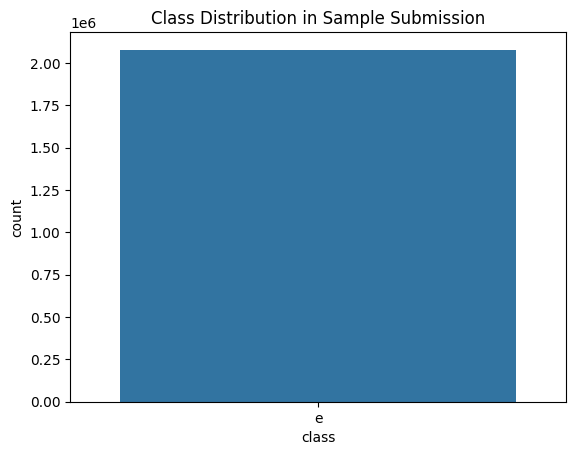

class
p    1246942
e     831022
Name: count, dtype: int64


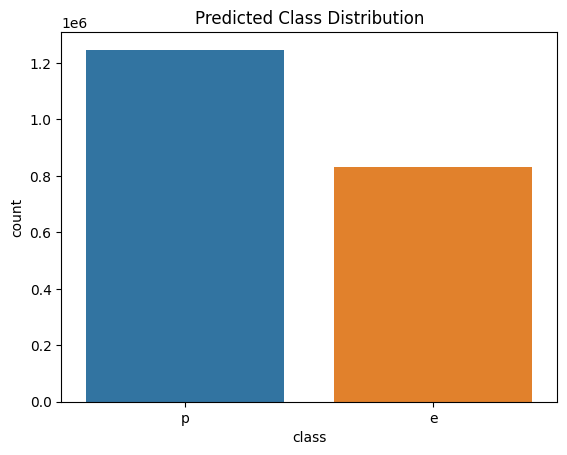

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Verify the class distribution in the sample_submission
class_distribution = df_sub['class'].value_counts()
print(class_distribution)

# Plot the distribution
sns.countplot(x='class', data=df_sub)
plt.title('Class Distribution in Sample Submission')
plt.show()

# Check model predictions
predicted_class_distribution = results_df['class'].value_counts()
print(predicted_class_distribution)

# Plot the distribution of model predictions
sns.countplot(x='class', data=results_df)
plt.title('Predicted Class Distribution')
plt.show()


In [55]:
# Calculate MCC
mcc = matthews_corrcoef(merged_df['class_true'], merged_df['class_pred'])

# Display the MCC
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

Matthews Correlation Coefficient: 0.0000
